In [53]:
pip install trimesh

In [1]:
import os
import random
import glob
import trimesh
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import scipy 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv3D, Dense ,Dropout, Flatten, Activation, MaxPooling3D, Input

from tensorflow.keras.layers import Convolution2D,Conv2D, Dense,Dropout, Flatten, Activation, MaxPooling2D, Input, Conv1D, GlobalAveragePooling1D, TimeDistributed, GRU, LSTM

from sklearn.model_selection import train_test_split, KFold,StratifiedKFold
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



2022-01-04 21:02:26.289097: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0


In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive')

    print("reading from cloud...")
    path = "/content/drive/MyDrive/data_70p_overhang/stls_opt/"
    path_vox = "/content/drive/MyDrive/data_70p_overhang/voxels/"
    
except:
    import pathlib
    print("reading from disk")
    path = str(pathlib.Path().resolve())+"/dataset/stls_opt/"
    path_vox = str(pathlib.Path().resolve())+"/dataset/voxels/"

reading from disk


In [56]:
mesh = trimesh.load(path+"63_8475_10313_17790_28845.stl")

In [3]:
def augment(points):
    # jitter points
    points += tf.random.uniform(points.shape, -0.05, 0.05, dtype=tf.float32)
    # shuffle points
    points = tf.random.shuffle(points)
    return points

def calculate_cost(filename):
  #params
  #time - parts usally need 15 minutes for preparation
  #1h - 10eur
  price_per_h = 2
  price_per_meter = 0.17#0.1133 #150 meters costs 17e 
  filament_diameter = 2.85 #mm
  filament_phi = np.power(filament_diameter/2,2)*np.pi #mm^2
  
  support_removal_multiplier= 2
  support_removal_multiplier_time = 1.5
  profit_margin = 0.1
  #larger parts need longer time + 5 minutes slice time. 
  
  #get data from filename
  data = filename.replace(".","_").split("_")
  data = [int(x) for x in data[:-1]]

  #calculate cost from filament lenght

  #calulate cost no support 
  cost_filament = ((data[2]/(filament_phi*1000)))*price_per_meter

  #calulcate cost of printing supports only 
  cost_supports = (abs(data[2]-data[4])/(filament_phi*1000))*price_per_meter
  cost_supports_removal = support_removal_multiplier*cost_supports

  #calulate timewise cost in hours
  print_time = data[1]
  print_time_supports = data[3]

  #convert to horus and include time for removing supports 
  print_time= (((print_time + 2*abs(print_time-print_time_supports))*support_removal_multiplier_time)/3600)
  print_time_cost = print_time * price_per_h

  #cena
  cost = (cost_filament+cost_supports+cost_supports_removal+print_time_cost)
  cost = (cost*profit_margin)+cost

  return cost

In [19]:
n_samples = 4096
n_aug_samples = 1
X = np.zeros([0,n_samples,3])

X_volume = np.zeros([0,1])
X_area = np.zeros([0,1])

y= np.zeros(0)

for filename in os.listdir(path):
    if filename.endswith(".stl"):
        print("appending", filename)
        mesh = trimesh.load(path+filename)
        points = mesh.sample(n_samples)
        
        for n in range(n_aug_samples):

            points = augment(points)
            X = np.append(X,points[np.newaxis,...],axis=0)

            cost = calculate_cost(filename)
            y = np.append(y,cost)

            mv = np.array(abs(mesh.volume))
            X_volume = np.append(X_volume,mv[np.newaxis,...])

            ma = np.array(abs(mesh.area))
            X_area = np.append(X_area,ma[np.newaxis,...])

X_area = X_area[...,np.newaxis]
X_volume = X_volume[...,np.newaxis]
X = X

appending 156_9011_10918_9011_10918.stl
appending 170_2455_3762_2455_3762.stl
appending 116_8483_11847_8483_11847.stl
appending 57_5137_7748_5263_7807.stl
appending 122_11186_19511_13726_22635.stl
appending 93_16752_18346_26298_32600.stl
appending 17_7383_11480_7541_11729.stl
appending 90_6007_8420_6007_8420.stl
appending 185_591_712_591_712.stl
appending 117_9588_12888_9588_12888.stl
appending 54_2304_3599_2501_3836.stl
appending 28_49079_88979_56070_101428.stl
appending 192_61746_89353_64214_90531.stl
appending 8_92217_167844_92549_168286.stl
appending 85_16507_22010_19998_25601.stl
appending 174_33944_64869_33943_64868.stl
appending 2_12292_15295_12292_15295.stl
appending 131_8772_13089_9335_13633.stl
appending 175_51486_60378_59690_73429.stl
appending 108_31956_48635_34435_50936.stl
appending 39_10253_15455_12569_18131.stl
appending 66_24071_33123_24568_33550.stl
appending 183_5245_7881_5384_7941.stl
appending 20_27655_40122_29843_42884.stl
appending 179_7556_4591_10558_6339.stl
ap

In [20]:
n_samples = X.shape[0]
train_ind, test_ind  = train_test_split(range(n_samples), test_size=0.2, random_state=36)

X_train = X[train_ind]
X_train_volume = X_volume[train_ind]
X_train_area = X_area[train_ind]
y_train = y[train_ind]

X_test = X[test_ind]
X_test_volume = X_volume[test_ind]
X_test_area = X_area[test_ind]
y_test = y[test_ind]

print("train",X_train.shape,X_train_volume.shape,X_train_area.shape)
print("test",X_test.shape,X_test_volume.shape,X_test_area.shape)

train (156, 4096, 3) (156, 1) (156, 1)
test (40, 4096, 3) (40, 1) (40, 1)


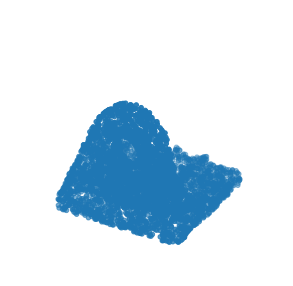

In [60]:
points = mesh.sample(5000)
#points = augment(points)
for points in X_train:
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111,projection="3d")
    ax.scatter(points[:, 0], points[:, 2], points[:, 1])
    ax.set_axis_off()
    plt.show()
    break

In [23]:
input1 = keras.Input(shape=(X_train.shape[1:]))
input2 = keras.Input(shape=(X_train_volume.shape[1:]))
input3 = keras.Input(shape=(X_train_area.shape[1:]))


x = tnet(input1, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
#x = layers.Dropout(0.3)(x)

x = Activation('relu')(x)


x = Flatten()(x)

x = layers.Concatenate()([x,input2])
x = layers.Concatenate()([x,input3])


dense = Dense(2000, activation = 'relu')(x)
dense = Dense(300, activation = 'relu')(dense)
dense = Dense(150, activation = 'relu')(dense)
dense = Dense(20, activation = 'relu')(dense)
dense = Dense(16, activation = 'relu')(dense)
    # final layer with 10 neurons to classify the instances
output = Dense(1, activation = 'linear')(dense)
    
#outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = keras.Model(inputs=[input1,input2,input3], outputs=output, name="jjnet")
#model.summary()

In [22]:
def augment(points):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points

#fuctions to build models 
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

#function to create T-net layers
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

def min_max(img):

    img =(img -(np.min(img)))
    img = img/np.max(img)
    return img

In [34]:
model.compile(
    loss="MAE",
    optimizer=keras.optimizers.Adam(learning_rate=0.00005),
    metrics=["MAPE"],
)

model.fit([X_train,np.log(X_train_volume), np.log(X_train_area)], np.log(y_train),validation_split = 0.2, batch_size = 8, epochs = 100, verbose = 1)


Epoch 1/100
16/16 [==============================] - 3s 68ms/step - loss: 0.7357 - MAPE: 74.7748 - val_loss: 22020.7148 - val_MAPE: 39062.4531
Epoch 2/100
16/16 [==============================] - 1s 38ms/step - loss: 0.6744 - MAPE: 73.9676 - val_loss: 19.8750 - val_MAPE: 1084.2288
Epoch 3/100
16/16 [==============================] - 1s 38ms/step - loss: 0.7264 - MAPE: 115.4714 - val_loss: 33110.7109 - val_MAPE: 11568.2314
Epoch 4/100
16/16 [==============================] - 1s 38ms/step - loss: 0.6728 - MAPE: 64.1862 - val_loss: 26.7984 - val_MAPE: 846.2438
Epoch 5/100
16/16 [==============================] - 1s 37ms/step - loss: 0.7484 - MAPE: 112.5767 - val_loss: 847.3550 - val_MAPE: 6283.1367
Epoch 6/100
16/16 [==============================] - 1s 38ms/step - loss: 0.6946 - MAPE: 77.3205 - val_loss: 12.6528 - val_MAPE: 433.2521
Epoch 7/100
16/16 [==============================] - 1s 38ms/step - loss: 0.6594 - MAPE: 61.2784 - val_loss: 8.8405 - val_MAPE: 254.6492
Epoch 8/100
16/16 [=

16/16 [==============================] - 1s 38ms/step - loss: 0.6238 - MAPE: 126.1183 - val_loss: 10.6210 - val_MAPE: 509.7880
Epoch 60/100
16/16 [==============================] - 1s 38ms/step - loss: 0.5855 - MAPE: 54.1503 - val_loss: 870.4257 - val_MAPE: 3370.4912
Epoch 61/100
16/16 [==============================] - 1s 38ms/step - loss: 0.6439 - MAPE: 56.1435 - val_loss: 121.6552 - val_MAPE: 2831.2195
Epoch 62/100
16/16 [==============================] - 1s 38ms/step - loss: 0.6533 - MAPE: 60.4743 - val_loss: 40.9335 - val_MAPE: 1089.7555
Epoch 63/100
16/16 [==============================] - 1s 38ms/step - loss: 0.6819 - MAPE: 93.2067 - val_loss: 25.4192 - val_MAPE: 685.0806
Epoch 64/100
16/16 [==============================] - 1s 38ms/step - loss: 0.6142 - MAPE: 45.1806 - val_loss: 67.8248 - val_MAPE: 1317.2870
Epoch 65/100
16/16 [==============================] - 1s 38ms/step - loss: 0.5953 - MAPE: 47.7683 - val_loss: 21.4405 - val_MAPE: 730.9036
Epoch 66/100
16/16 [=============

In [63]:
model.evaluate([X_test, np.log(X_test_volume),np.log(X_test_area)],y_test)

7/7 [==============================] - 1s 129ms/step - loss: 3166.6201 - MAPE: 122.7453


[3166.6201171875, 122.74531555175781]

In [36]:
preds = model.predict([X_test, np.log(X_test_volume),np.log(X_test_area)])#*y_train_max

In [11]:
#mae
print(np.sum(abs(np.exp(preds)-(y_test)))/len(preds),np.sum(abs(((preds)-(np.log(y_train)))))/len(preds))

inf 268490484.524725


/tmp/ipykernel_52656/3315858005.py:2: RuntimeWarning: overflow encountered in exp
  print(np.sum(abs(np.exp(preds)-(y_test)))/len(preds),np.sum(abs(((preds)-(np.log(y_train)))))/len(preds))


In [66]:
np.sum(abs(np.exp(preds)-(y_test)))/len(preds)

6.765683553595907e+26

In [37]:
mae = 0
mape = 0
rmse = 0
c = 0
for e,i in zip(np.exp(preds),y_test):
  mae = mae + abs(e-i)
  mape = mape + abs((e-i)/i)
  rmse = rmse + np.power((i-e),2)
  c = c +1 
  print("Predikcija",round(e[0],2)," Cena ",round(i,2))
print("MAE",mae/c)
print("MAPE",mape/c)
print("RMSE",np.sqrt(rmse/c))

Predikcija 0.0  Cena  1.64
Predikcija 3.12  Cena  37.83
Predikcija 3.12  Cena  18.86
Predikcija 0.0  Cena  117.49
Predikcija 6.09  Cena  8.99
Predikcija 1.64  Cena  38.64
Predikcija 5.84  Cena  9.74
Predikcija 0.0  Cena  252.68
Predikcija 0.0  Cena  38.4
Predikcija 0.0  Cena  107.3
Predikcija 14.32  Cena  22.49
Predikcija 0.0  Cena  123.51
Predikcija 2.14  Cena  2.6
Predikcija 17.07  Cena  29.22
Predikcija 0.01  Cena  18.83
Predikcija 0.0  Cena  3.91
Predikcija 0.0  Cena  66.36
Predikcija 0.6  Cena  13.69
Predikcija 0.69  Cena  0.67
Predikcija 0.5  Cena  1.76
Predikcija 0.0  Cena  11.72
Predikcija 11.67  Cena  19.68
Predikcija 0.0  Cena  0.42
Predikcija 8.28  Cena  13.95
Predikcija 0.51  Cena  2.72
Predikcija 4.8  Cena  10.5
Predikcija 8.56  Cena  16.09
Predikcija 0.21  Cena  0.45
Predikcija 0.03  Cena  11.34
Predikcija 0.0  Cena  1.24
Predikcija 10.17  Cena  14.49
Predikcija 0.0  Cena  9.04
Predikcija 11.97  Cena  19.35
Predikcija 0.0  Cena  58.71
Predikcija 4.47  Cena  10.48
Predikci

In [38]:
for e,i in zip(np.exp(preds),y_test):
  print(round(e[0],2),",",round(i,2))

print(mae/c)
print(mape/c)
print(np.sqrt(rmse/c))

0.0 , 1.64
3.12 , 37.83
3.12 , 18.86
0.0 , 117.49
6.09 , 8.99
1.64 , 38.64
5.84 , 9.74
0.0 , 252.68
0.0 , 38.4
0.0 , 107.3
14.32 , 22.49
0.0 , 123.51
2.14 , 2.6
17.07 , 29.22
0.01 , 18.83
0.0 , 3.91
0.0 , 66.36
0.6 , 13.69
0.69 , 0.67
0.5 , 1.76
0.0 , 11.72
11.67 , 19.68
0.0 , 0.42
8.28 , 13.95
0.51 , 2.72
4.8 , 10.5
8.56 , 16.09
0.21 , 0.45
0.03 , 11.34
0.0 , 1.24
10.17 , 14.49
0.0 , 9.04
11.97 , 19.35
0.0 , 58.71
4.47 , 10.48
3.17 , 5.66
10.51 , 31.06
0.52 , 3.42
0.35 , 0.59
0.19 , 0.44
[25.635777]
[0.7105125]
[54.41407]


In [43]:
#point net 
verbose_mode = 1
epochs_per_round = 25
seeds = [12,36,42]
#seeds = [42]
rounds_lr = [0.0001,0.00008,0.00006,0.00004,0.00001]#0.000005,0.000004,0.000002]

for seed in seeds:

    print("______________________________________________")


    n_samples = X.shape[0]
    train_ind, test_ind  = train_test_split(range(n_samples), test_size=0.2, random_state=seed)

    X_train = X[train_ind]
    X_train_volume = X_volume[train_ind]
    X_train_area = X_area[train_ind]
    y_train = y[train_ind]

    X_test = X[test_ind]
    X_test_volume = X_volume[test_ind]
    X_test_area = X_area[test_ind]
    y_test = y[test_ind]

    print("train",X_train.shape,X_train_volume.shape,X_train_area.shape)
    print("test",X_test.shape,X_test_volume.shape,X_test_area.shape)
            
    input1 = keras.Input(shape=(X_train.shape[1:]))
    input2 = keras.Input(shape=(X_train_volume.shape[1:]))
    input3 = keras.Input(shape=(X_train_area.shape[1:]))

    x = tnet(input1, 3)
    x = conv_bn(x, 32)
    x = conv_bn(x, 32)
    x = tnet(x, 32)
    x = conv_bn(x, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = layers.Dropout(0.3)(x)
    x = dense_bn(x, 128)
    #x = layers.Dropout(0.3)(x)

    x = Activation('relu')(x)

    x = Flatten()(x)

    x = layers.Concatenate()([x,input2])
    x = layers.Concatenate()([x,input3])


    dense = Dense(2000, activation = 'relu')(x)
    dense = Dense(300, activation = 'relu')(dense)
    dense = Dense(150, activation = 'relu')(dense)
    dense = Dense(20, activation = 'relu')(dense)
    dense = Dense(16, activation = 'relu')(dense)
        # final layer with 10 neurons to classify the instances
    output = Dense(1, activation = 'linear')(dense)

    #outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
    model = keras.Model(inputs=[input1,input2,input3], outputs=output, name="pointnet")
    #model.summary()
        
    for round_lr in rounds_lr:
        
        print(" ")
        print("starting round lr",round_lr," and seed",seed)
        
        model.compile(
            loss="MAE",
            optimizer=keras.optimizers.Adam(learning_rate=round_lr),
            metrics=["MAPE"],
        )

        model.fit([X_train,np.log(X_train_volume), np.log(X_train_area)], np.log(y_train), batch_size = 8, epochs = epochs_per_round, verbose = verbose_mode)
        
        preds = model.predict([X_test, np.log(X_test_volume),np.log(X_test_area)])#*y_train_max
        
        mae = 0
        mape = 0
        rmse = 0
        c = 0
        for e,i in zip(np.exp(preds),y_test):
          mae = mae + abs(e-i)
          mape = mape + abs((e-i)/i)
          rmse = rmse + np.power((i-e),2)
          c = c +1 
        
        for e,i in zip(np.exp(preds),y_test):
          print(round(e[0],2),",",round(i,2))

        print(mae/c)
        print(mape/c)
        print(np.sqrt(rmse/c))
        
        print("next round !")


______________________________________________
train (156, 4096, 3) (156, 1) (156, 1)
test (40, 4096, 3) (40, 1) (40, 1)
 
starting round lr 0.0001  and seed 12
Epoch 1/25
20/20 [==============================] - 3s 32ms/step - loss: 2.4588 - MAPE: 102.2845
Epoch 2/25
20/20 [==============================] - 1s 31ms/step - loss: 1.3036 - MAPE: 181.9412
Epoch 3/25
20/20 [==============================] - 1s 31ms/step - loss: 1.0417 - MAPE: 173.6169
Epoch 4/25
20/20 [==============================] - 1s 31ms/step - loss: 0.9684 - MAPE: 126.2961
Epoch 5/25
20/20 [==============================] - 1s 31ms/step - loss: 0.9150 - MAPE: 89.8456
Epoch 6/25
20/20 [==============================] - 1s 31ms/step - loss: 0.9216 - MAPE: 79.9640
Epoch 7/25
20/20 [==============================] - 1s 31ms/step - loss: 0.8317 - MAPE: 65.3453
Epoch 8/25
20/20 [==============================] - 1s 31ms/step - loss: 0.9235 - MAPE: 71.7506
Epoch 9/25
20/20 [==============================] - 1s 31ms/step - 

20/20 [==============================] - 1s 31ms/step - loss: 0.6497 - MAPE: 80.4840
Epoch 23/25
20/20 [==============================] - 1s 31ms/step - loss: 0.6481 - MAPE: 45.0874
Epoch 24/25
20/20 [==============================] - 1s 31ms/step - loss: 0.6120 - MAPE: 45.8715
Epoch 25/25
20/20 [==============================] - 1s 31ms/step - loss: 0.6368 - MAPE: 41.2575
0.0 , 132.82
0.0 , 61.51
0.0 , 252.68
0.0 , 26.78
0.0 , 23.98
0.0 , 1.39
0.12 , 4.62
0.0 , 30.78
0.2 , 5.75
0.0 , 108.8
0.0 , 0.34
0.0 , 30.84
0.0 , 171.18
0.0 , 66.36
0.0 , 27.72
0.0 , 49.05
0.42 , 5.41
0.05 , 5.15
0.0 , 0.95
0.0 , 40.57
0.38 , 5.34
0.0 , 7.88
0.51 , 5.85
10.38 , 10.23
8.52 , 9.74
1.51 , 10.5
1.3 , 14.49
0.0 , 51.93
0.02 , 34.17
0.51 , 6.8
0.0 , 38.22
0.0 , 38.4
0.0 , 1.99
0.01 , 2.36
0.01 , 34.65
0.0 , 0.88
0.0 , 4.21
0.03 , 5.75
0.02 , 22.49
0.0 , 44.14
[34.32528]
[0.93769586]
[61.208042]
next round !
 
starting round lr 4e-05  and seed 12
Epoch 1/25
20/20 [==============================] - 3s 32m

20/20 [==============================] - 1s 31ms/step - loss: 0.8569 - MAPE: 96.1699
Epoch 13/25
20/20 [==============================] - 1s 31ms/step - loss: 0.8909 - MAPE: 126.3172
Epoch 14/25
20/20 [==============================] - 1s 31ms/step - loss: 0.7722 - MAPE: 88.7711
Epoch 15/25
20/20 [==============================] - 1s 31ms/step - loss: 0.7670 - MAPE: 124.3582
Epoch 16/25
20/20 [==============================] - 1s 31ms/step - loss: 0.7846 - MAPE: 89.6316
Epoch 17/25
20/20 [==============================] - 1s 31ms/step - loss: 0.7709 - MAPE: 56.5313
Epoch 18/25
20/20 [==============================] - 1s 31ms/step - loss: 0.7273 - MAPE: 60.0800
Epoch 19/25
20/20 [==============================] - 1s 31ms/step - loss: 0.7803 - MAPE: 113.3966
Epoch 20/25
20/20 [==============================] - 1s 31ms/step - loss: 0.7073 - MAPE: 43.9330
Epoch 21/25
20/20 [==============================] - 1s 31ms/step - loss: 0.7272 - MAPE: 78.1433
Epoch 22/25
20/20 [====================

20/20 [==============================] - 1s 31ms/step - loss: 0.6105 - MAPE: 43.7224
Epoch 4/25
20/20 [==============================] - 1s 31ms/step - loss: 0.6771 - MAPE: 55.2685
Epoch 5/25
20/20 [==============================] - 1s 31ms/step - loss: 0.6562 - MAPE: 93.2586
Epoch 6/25
20/20 [==============================] - 1s 31ms/step - loss: 0.6804 - MAPE: 69.5330
Epoch 7/25
20/20 [==============================] - 1s 31ms/step - loss: 0.7057 - MAPE: 82.2850
Epoch 8/25
20/20 [==============================] - 1s 31ms/step - loss: 0.6286 - MAPE: 53.0553
Epoch 9/25
20/20 [==============================] - 1s 31ms/step - loss: 0.6525 - MAPE: 52.4484
Epoch 10/25
20/20 [==============================] - 1s 31ms/step - loss: 0.6117 - MAPE: 79.7085
Epoch 11/25
20/20 [==============================] - 1s 31ms/step - loss: 0.6442 - MAPE: 60.2652
Epoch 12/25
20/20 [==============================] - 1s 31ms/step - loss: 0.6027 - MAPE: 47.5978
Epoch 13/25
20/20 [=============================

20/20 [==============================] - 1s 31ms/step - loss: 0.9032 - MAPE: 77.6563
Epoch 25/25
20/20 [==============================] - 1s 31ms/step - loss: 0.6879 - MAPE: 60.0290
1.3 , 6.58
16.09 , 53.01
8.34 , 11.72
1.83 , 1.64
0.03 , 0.95
0.0 , 41.26
0.0 , 6.71
0.0 , 132.82
0.0 , 65.15
0.0 , 38.4
1.15 , 11.01
0.0 , 33.02
2.75 , 58.53
0.0 , 126.64
0.01 , 120.61
0.46 , 0.4
1.03 , 1.99
12.51 , 9.17
1.19 , 3.91
14.2 , 15.18
1.95 , 5.86
2.46 , 3.35
27.6 , 7.07
0.01 , 0.17
18.27 , 29.22
0.0 , 81.17
0.31 , 1.31
2.16 , 5.38
1.11 , 4.33
6.4 , 12.19
4.29 , 5.13
15.89 , 18.29
0.0 , 38.24
0.0 , 12.72
10.83 , 7.28
2.48 , 5.15
0.0 , 69.82
0.0 , 35.47
0.0 , 126.5
0.0 , 17.66
[28.142254]
[0.7629031]
[48.143562]
next round !
 
starting round lr 8e-05  and seed 42
Epoch 1/25
20/20 [==============================] - 3s 32ms/step - loss: 0.6996 - MAPE: 45.6300
Epoch 2/25
20/20 [==============================] - 1s 31ms/step - loss: 0.7461 - MAPE: 74.7496
Epoch 3/25
20/20 [============================

20/20 [==============================] - 1s 31ms/step - loss: 0.6102 - MAPE: 53.9220
Epoch 17/25
20/20 [==============================] - 1s 31ms/step - loss: 0.6871 - MAPE: 106.5396
Epoch 18/25
20/20 [==============================] - 1s 31ms/step - loss: 0.6266 - MAPE: 37.5462
Epoch 19/25
20/20 [==============================] - 1s 31ms/step - loss: 0.6257 - MAPE: 37.3762
Epoch 20/25
20/20 [==============================] - 1s 31ms/step - loss: 0.6529 - MAPE: 52.7758
Epoch 21/25
20/20 [==============================] - 1s 31ms/step - loss: 0.6049 - MAPE: 32.8159
Epoch 22/25
20/20 [==============================] - 1s 31ms/step - loss: 0.6181 - MAPE: 61.8691
Epoch 23/25
20/20 [==============================] - 1s 31ms/step - loss: 0.5932 - MAPE: 38.0225
Epoch 24/25
20/20 [==============================] - 1s 31ms/step - loss: 0.5514 - MAPE: 35.5575
Epoch 25/25
20/20 [==============================] - 1s 31ms/step - loss: 0.6417 - MAPE: 51.7928
7.39 , 6.58
0.0 , 53.01
0.0 , 11.72
0.0 ,